# The ipynb file tests and display the results form .py files

In [1]:
#%%

%load_ext autoreload
%autoreload 2


import numpy as np
import numpy.random as rd
from scipy import stats
import synthetic_data as sdata

In [3]:
np.random.seed(1)
# p_index, test_data, cost = sdata.create_synthetic_data(25, 7, 100, 5, 64, 23, 3)
p_index, test_data, cost = sdata.create_synthetic_data(5, 5, 100, 2, 10, 23, 3)
print(f"test_data has shape: {test_data.shape}\ncost has shape: {cost.shape}\n")
print("first vector in data set:\n",np.round(test_data[0]))
cost_display = cost[0:min(len(cost),10)]
print("\nfirst ten element in cost vector:\n",cost)
print("the index for problems: ",p_index)

# print(p_index)
# print(np.round(test_data))
# print(cost)


test_data has shape: (29, 55)
cost has shape: (29, 2)

first vector in data set:
 [ 3. 20. 11. 12. 14.  2.  0.  4.  1.  0.  4.  1.  4.  4.  2.  3.  1.  0.
  1.  3.  1.  1.  4.  4.  2.  1.  0.  3.  3.  1.  1.  2.  4.  1.  1.  0.
  1.  0.  1.  3.  2.  0.  3.  1.  2.  2.  3.  1.  1.  3.  1.  2.  4.  4.
  2.]

first ten element in cost vector:
 [[ 8  0]
 [53  0]
 [70  0]
 [58  0]
 [63  0]
 [90  0]
 [84  0]
 [17  1]
 [29  1]
 [46  1]
 [83  1]
 [82  1]
 [69  2]
 [68  2]
 [62  2]
 [84  2]
 [70  2]
 [39  2]
 [75  3]
 [64  3]
 [73  4]
 [13  4]
 [35  4]
 [25  4]
 [84  4]
 [35  4]
 [23  4]
 [90  4]
 [41  4]]
the index for problems:  [ 0  7 12 18 20 29]


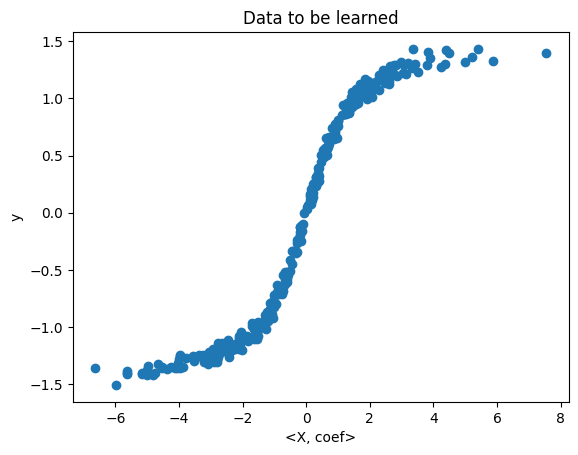

Performance of ranking  0.9787878787878788
Performance of linear regression  0.9587570621468926


In [4]:
"""
https://gist.github.com/agramfort/2071994

Implementation of pairwise ranking using scikit-learn LinearSVC
Reference: "Large Margin Rank Boundaries for Ordinal Regression", R. Herbrich,
    T. Graepel, K. Obermayer.
Authors: Fabian Pedregosa <fabian@fseoane.net>
         Alexandre Gramfort <alexandre.gramfort@inria.fr>
"""

import itertools
import numpy as np

from sklearn import svm, linear_model
from sklearn.model_selection import KFold


def transform_pairwise(X, y):
    """Transforms data into pairs with balanced labels for ranking
    Transforms a n-class ranking problem into a two-class classification
    problem. Subclasses implementing particular strategies for choosing
    pairs should override this method.
    In this method, all pairs are choosen, except for those that have the
    same target value. The output is an array of balanced classes, i.e.
    there are the same number of -1 as +1
    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,) or (n_samples, 2)
        Target labels. If it's a 2D array, the second column represents
        the grouping of samples, i.e., samples with different groups will
        not be considered.
    Returns
    -------
    X_trans : array, shape (k, n_feaures)
        Data as pairs
    y_trans : array, shape (k,)
        Output class labels, where classes have values {-1, +1}
    """
    X_new = []
    y_new = []
    y = np.asarray(y)
    if y.ndim == 1:
        y = np.c_[y, np.ones(y.shape[0])]
    comb = itertools.combinations(range(X.shape[0]), 2)
    for k, (i, j) in enumerate(comb):
        if y[i, 0] == y[j, 0] or y[i, 1] != y[j, 1]:
            # skip if same target or different group
            continue
        X_new.append(X[i] - X[j])
        y_new.append(np.sign(y[i, 0] - y[j, 0]))
#         output balanced classes
        if y_new[-1] != (-1) ** k:
            y_new[-1] = - y_new[-1]
            X_new[-1] = - X_new[-1]
    return np.asarray(X_new), np.asarray(y_new).ravel()


class RankSVM(svm.LinearSVC):
    """Performs pairwise ranking with an underlying LinearSVC model
    Input should be a n-class ranking problem, this object will convert it
    into a two-class classification problem, a setting known as
    `pairwise ranking`.
    See object :ref:`svm.LinearSVC` for a full description of parameters.
    """

    def fit(self, X, y):
        """
        Fit a pairwise ranking model.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,) or (n_samples, 2)
        Returns
        -------
        self
        """
        X_trans, y_trans = transform_pairwise(X, y)
        super(RankSVM, self).fit(X_trans, y_trans)
        return self

    def predict(self, X):
        """
        Predict an ordering on X. For a list of n samples, this method
        returns a list from 0 to n-1 with the relative order of the rows of X.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        Returns
        -------
        ord : array, shape (n_samples,)
            Returns a list of integers representing the relative order of
            the rows in X.
        """
        if hasattr(self, 'coef_'):
            return np.argsort(np.dot(X, self.coef_.T).flatten())
        else:
            raise ValueError("Must call fit() prior to predict()")

    def score(self, X, y):
        """
        Because we transformed into a pairwise problem, chance level is at 0.5
        """
        X_trans, y_trans = transform_pairwise(X, y)
        return np.mean(super(RankSVM, self).predict(X_trans) == y_trans)


if __name__ == '__main__':
    # as showcase, we will create some non-linear data
    # and print the performance of ranking vs linear regression

    np.random.seed(1)
    n_samples, n_features = 300, 5
    true_coef = np.random.randn(n_features)
    X = np.random.randn(n_samples, n_features)
    noise = np.random.randn(n_samples) / np.linalg.norm(true_coef)
    y = np.dot(X, true_coef)
    y = np.arctan(y)  # add non-linearities
    y += .1 * noise  # add noise
    Y = np.c_[y, np.mod(np.arange(n_samples), 5)]  # add query fake id
    cv = KFold(n_splits=5)
    train, test = cv.split(X, y).__next__()

    # make a simple plot out of it
    import pylab as pl

    pl.scatter(np.dot(X, true_coef), y)
    pl.title('Data to be learned')
    pl.xlabel('<X, coef>')
    pl.ylabel('y')
    pl.show()

    # print the performance of ranking
    rank_svm = RankSVM().fit(X[train], Y[train])
    print('Performance of ranking ', rank_svm.score(X[test], Y[test]))

    # and that of linear regression
    ridge = linear_model.RidgeCV(fit_intercept=True)
    ridge.fit(X[train], y[train])
    X_test_trans, y_test_trans = transform_pairwise(X[test], y[test])
    score = np.mean(np.sign(np.dot(X_test_trans, ridge.coef_)) == y_test_trans)
    print('Performance of linear regression ', score)

In [156]:
X_trans, y_trans = transform_pairwise(np.round(test_data), cost)

In [157]:
print(np.round(X_trans), y_trans)

[[ 21. -12.  -1. ...  -1.  -3.  -1.]
 [ -3.   7. -12. ...   1.   1.   0.]
 [  7.  -9.   8. ...  -2.  -1.  -1.]
 ...
 [ 10.   4.   3. ...  -2.  -3.  -3.]
 [  4.  -5.   2. ...   1.   1.   4.]
 [ 14.  -1.   5. ...  -1.  -2.   1.]] [ 1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1
  1  1 -1  1  1 -1 -1  1 -1  1 -1  1  1 -1  1 -1 -1  1 -1 -1  1  1 -1  1
 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1  1 -1  1 -1  1 -1  1 -1
  1 -1  1 -1  1 -1  1 -1  1 -1]


In [158]:
rank_svm = RankSVM().fit(test_data, cost)
for i in range(len(p_index)-1):
    print("the order for the rank_svm:",rank_svm.predict(test_data[p_index[i]:p_index[i+1]]))
    print("the order for the true cost:",np.argsort(cost[p_index[i]:p_index[i+1],0].flatten()))

1
the order for the rank_svm: [0 1 3 4 2 6 5]
the order for the true cost: [0 1 3 4 2 6 5]
1
the order for the rank_svm: [0 1 2 4 3]
the order for the true cost: [0 1 2 4 3]
1
the order for the rank_svm: [5 2 1 0 4 3]
the order for the true cost: [5 2 1 0 4 3]
1
the order for the rank_svm: [1 0]
the order for the true cost: [1 0]
1
the order for the rank_svm: [1 6 3 2 5 8 0 4 7]
the order for the true cost: [1 6 3 2 5 8 0 4 7]


D:\anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [93]:
print(np.round(cost))

[[76  0]
 [36  0]
 [54  0]
 [94  1]
 [34  1]
 [ 3  2]
 [85  2]
 [84  3]
 [49  3]
 [55  3]
 [33  4]
 [29  4]
 [56  4]]


In [137]:
X = test_data[p_index[0]:p_index[1]]
y = np.argsort(cost[p_index[0]:p_index[1],0].flatten())
rankings = rankSVM(X, y, tau=1.0)
print(rankings)
print(y)

Kendall rank correlation coefficient: -0.1173054587688734
Final Kendall rank correlation coefficient: -0.1173054587688734
[ 1 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 23 22 21 20  2  3
  4  5  6  7  8  9 41 10 12 13 14 15 16 17 18 19 11 42]
[39 29  2 33  4 26 36  0 16  8  6 28 23 41  9 31 12 21  1 22 30  7 20 10
  3  5 32 37 40 38 14 11 35 24 25 27 19 34 18 13 17 15]


In [159]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

class RankingSVM(SGDClassifier):
    def __init__(self, *args, **kwargs):
        super(RankingSVM, self).__init__(*args, **kwargs, loss='hinge', penalty='l2')

    def transform_to_pairs(self, X, y):
        X_pairs = []
        y_pairs = []
        n_samples = X.shape[0]

        for i in range(n_samples):
            for j in range(i + 1, n_samples):
                X_pairs.append(X[i] - X[j])
                y_pairs.append(np.sign(y[i] - y[j]))

        return np.array(X_pairs), np.array(y_pairs)

    def fit(self, X, y):
        X_pairs, y_pairs = self.transform_to_pairs(X, y)
        return super(RankingSVM, self).fit(X_pairs, y_pairs)

    def predict(self, X):
        decision_values = self.decision_function(X)
        return np.argsort(decision_values)

In [161]:
X = test_data[p_index[0]:p_index[1]]
y = np.argsort(cost[p_index[0]:p_index[1],0].flatten())
ranksvm = RankingSVM()
ranksvm.fit(X, y)
print(ranksvm.predict(X))
print(y)

[0 1 4 3 2 6 5]
[0 1 3 4 2 6 5]


In [15]:
def ranking_from_pairwise_comparisons(X):
    A = int((-1 + (1 + 8 * len(X))**0.5) / 2) + 1
    scores = np.zeros(A)

    idx = 0
    for i in range(A):
        for j in range(i + 1, A):
            if X[idx] == 1:
                scores[i] += 1
            else:
                scores[j] += 1
            idx += 1


    return scores

# Test the algorithm with the given example
X = [1,1,1,1,1,1,1,1,1,-1]
Y = ranking_from_pairwise_comparisons(X)
print("Ranking index of Y:", Y)

Ranking index of Y: [4. 3. 2. 0. 1.]
